# Fine-tuning Donut for document parsing on Quandri's Insurance dataset

## Quick intro: Document Understanding Transformer (Donut) by ClovaAI

Document Understanding Transformer (Donut) is a new Transformer model for OCR-free document understanding. It doesn't require an OCR engine to process scanned documents but is achieving state-of-the-art performances on various visual document understanding tasks, such as visual document classification or information extraction (a.k.a. document parsing). 
Donut is a multimodal sequence-to-sequence model with a vision encoder ([Swin Transformer](https://huggingface.co/docs/transformers/v4.21.2/en/model_doc/swin#overview)) and text decoder ([BART](https://huggingface.co/docs/transformers/v4.21.2/en/model_doc/bart)). The encoder receives the images and computes it into an embedding, which is then passed to the decoder, which generates a sequence of tokens.

![donut](/home/harish3110/document-ai/assets/donut.png)

* Paper: https://arxiv.org/abs/2111.15664
* Official repo:  https://github.com/clovaai/donut

--- 

In [1]:
import os
import json
from pathlib import Path
import shutil
import random
import numpy as np

from datasets import load_dataset

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Now we have two folders inside the `data/` directory. One contains the images of the receipts and the other contains the OCR text. The nex step is to create a `metadata.json` file that contains the information about the images including the OCR-text. This is necessary for the `imagefolder` feature of `datasets`.

The `metadata.json` should look at the end similar to the example below.

```json
{"file_name": "0001.png", "text": "This is a golden retriever playing with a ball"}
{"file_name": "0002.png", "text": "A german shepherd"}
```

In our example will `"text"` column contain the OCR text of the image, which will later be used for creating the Donut specific format.

In [19]:
base_path = Path("/home/harish3110/document-ai/data/all_data")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")
# define metadata list
metadata_list = []

# parse metadata
for file_name in metadata_path.glob("*.json"):
  with open(file_name, "r") as json_file:
    # load json file
    data = json.load(json_file)
    # create "text" column with json string
    text = json.dumps(data)
    # add to metadata list if image exists
    if image_path.joinpath(f"{file_name.stem}.jpeg").is_file():    
      metadata_list.append({"text":text,"file_name":f"{file_name.stem}.jpeg"})
      # delete json file

# write jsonline file
with open(image_path.joinpath('metadata.jsonl'), 'w') as outfile:
    for entry in metadata_list:
        json.dump(entry, outfile)
        outfile.write('\n')

Now we can load the dataset using the `imagefolder` feature of `datasets`.

In [16]:
base_path = Path("/home/harish3110/document-ai/data/all_data")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")

# Load dataset
dataset = load_dataset("imagefolder", data_dir=image_path, split="train")

print(f"Dataset has {len(dataset)} images")
print(f"Dataset features are: {dataset.features.keys()}")

Resolving data files:   0%|          | 0/1722 [00:00<?, ?it/s]

Using custom data configuration default-6bc5c85ccbfa4be7


Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /home/harish3110/.cache/huggingface/datasets/imagefolder/default-6bc5c85ccbfa4be7/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.
Dataset has 1721 images
Dataset features are: dict_keys(['image', 'ground_truth'])


In [20]:
dataset

Dataset({
    features: ['image', 'ground_truth'],
    num_rows: 1721
})

Random sample is 1442
OCR text is {'gt_parse': '{"policy_number": "32154250", "effective_date": "Sep 03 , 2022", "expiry_date": "Sep 03 , 2023", "premium": "$ 350.00"}'}


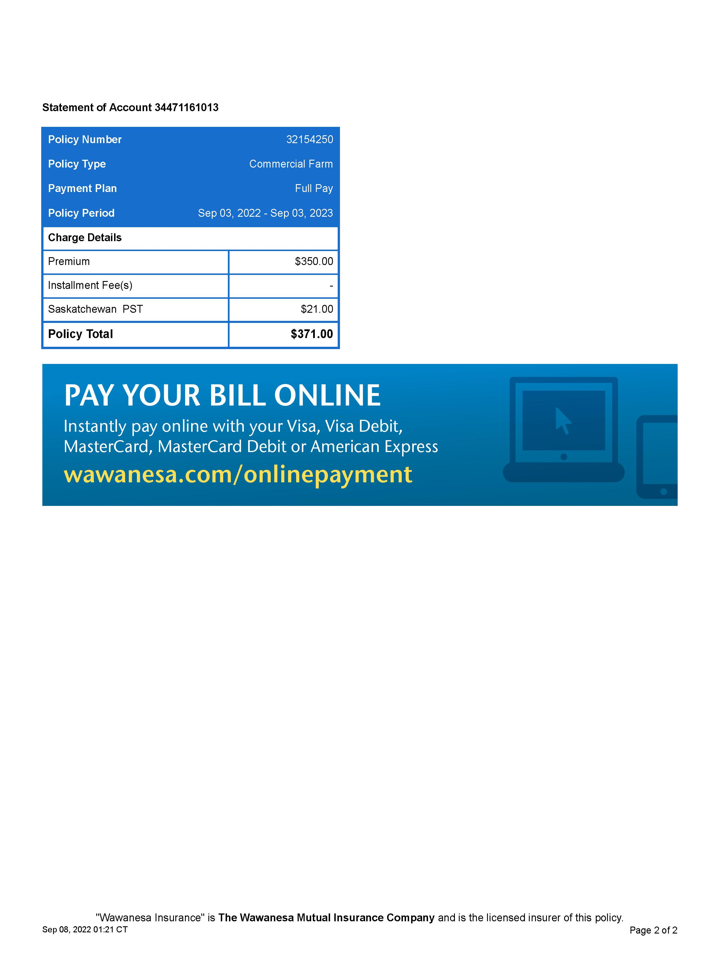

In [18]:
random_sample = random.randint(0, len(dataset))

print(f"Random sample is {random_sample}")
print(f"OCR text is {dataset[random_sample]['ground_truth']}")
dataset[random_sample]['image'].resize((720, 960))

## Prepare dataset for training using Donut

As we learned in the introduction, Donut is a sequence-to-sequence model with a vision encoder and text decoder. When fine-tuning the model we want it to generate the `"text"` based on the image we pass it. Similar to NLP tasks, we have to tokenize and preprocess the text. 
Before we can tokenize the text, we need to transform the JSON string into a Donut compatible document. 

**current JSON string**
```json
{"company": "ADVANCO COMPANY", "date": "17/01/2018", "address": "NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR", "total": "7.00"}
```

**Donut document**
```json
<s></s><s_company>ADVANCO COMPANY</s_company><s_date>17/01/2018</s_date><s_address>NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR</s_address><s_total>7.00</s_total></s>
```

To easily create those documents the ClovaAI team has created a [json2token](https://github.com/clovaai/donut/blob/master/donut/model.py#L497) method, which we extract and then apply.

In [6]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 1721
})

In [7]:
new_special_tokens = [] # new tokens which will be added to the tokenizer
task_start_token = "<s>"  # start of task token
eos_token = "</s>" # eos token of tokenizer

def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                    new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                    + fr"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        # excluded special tokens for now
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj


def preprocess_documents_for_donut(sample):
    # create Donut-style input
    text = json.loads(sample["text"])
    d_doc = task_start_token + json2token(text) + eos_token
    # convert all images to RGB
    image = sample["image"].convert('RGB')
    return {"image": image, "text": d_doc}


In [8]:
proc_dataset = dataset.map(preprocess_documents_for_donut)

  0%|          | 0/1721 [00:00<?, ?ex/s]

In [17]:
# The above code takes a lot of time to run, so we save the processed dataset to disk
from datasets import load_from_disk
from transformers import DonutProcessor

path = '/home/harish3110/document-ai/data'
proc_dataset.save_to_disk(f"{path}/proc_dataset")
proc_dataset = load_from_disk(f"{path}/proc_dataset")

In [18]:
print(f"Sample: {proc_dataset[45]['text']}")

Sample: <s><s_premium>( $ 458 )</s_premium><s_policy_number>P31252881-6</s_policy_number><s_effective_date>November 5 , 2022</s_effective_date><s_document_type_description>Policy Cover Page</s_document_type_description><s_document_type>Lapse OTR - Cancellation</s_document_type></s>


In [26]:
from transformers import DonutProcessor

# Load processor
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")

# add new special tokens to tokenizer
processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens + [task_start_token] + [eos_token]})

# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# resizing the image to smaller sizes from [1920, 2560] to [720, 960]
processor.feature_extractor.size = [720, 960] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [27]:
processor.tokenizer.is_fast

True

In [28]:
def transform_and_tokenize(sample, processor=processor, split="train", max_length=512, ignore_id=-100):
    # create tensor from image
    try:
        pixel_values = processor(
            sample["image"], random_padding=split == "train", return_tensors="pt"
        ).pixel_values.squeeze()
    except Exception as e:
        print(sample)
        print(f"Error: {e}")
        return {}
        
    # tokenize document
    input_ids = processor.tokenizer(
        sample["text"],
        add_special_tokens=False,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"].squeeze(0)

    labels = input_ids.clone()
    labels[labels == processor.tokenizer.pad_token_id] = ignore_id  # model doesn't need to predict pad token
    return {"pixel_values": pixel_values, "labels": labels, "target_sequence": sample["text"]}

processed_dataset = proc_dataset_1.map(transform_and_tokenize,remove_columns=["image","text"])

  0%|          | 0/861 [00:00<?, ?ex/s]

In [29]:
from datasets import load_from_disk
from transformers import DonutProcessor

path = '/home/harish3110/document-ai/data'

## COMMENT IN in case you want to save the processed dataset to disk in case of error later
# processed_dataset.save_to_disk(f"{path}/processed_dataset")
# processor.save_pretrained(f"{path}/processor")

## COMMENT IN in case you want to load the processed dataset from disk in case of error later
processed_dataset = load_from_disk(f"{path}/processed_dataset")
processor = DonutProcessor.from_pretrained(f"{path}/processor")

Saving the dataset (0/15 shards):   0%|          | 0/861 [00:00<?, ? examples/s]

In [30]:
processed_dataset = processed_dataset.train_test_split(test_size=0.1)
print(processed_dataset)

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 774
    })
    test: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 87
    })
})


## 4. Fine-tune and evaluate Donut model

After we have processed our dataset, we can start training our model. Therefore we first need to load the [naver-clova-ix/donut-base](https://huggingface.co/naver-clova-ix/donut-base) model with the `VisionEncoderDecoderModel` class. The `donut-base` includes only the pre-trained weights and was introduced in the paper [OCR-free Document Understanding Transformer](https://arxiv.org/abs/2111.15664) by Geewok et al. and first released in [this repository](https://github.com/clovaai/donut).

In addition to loading our model, we are resizing the `embedding` layer to match newly added tokens and adjusting the `image_size` of our encoder to match our dataset. We are also adding tokens for inference later.

In [31]:
import torch
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig

# Load model from huggingface.co
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")

# Resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))
print(f"New embedding size: {new_emb}")
# Adjust our image size and output sequence lengths
model.config.encoder.image_size = list(processor.feature_extractor.size.values()) # (height, width)
model.config.decoder.max_length = len(max(processed_dataset["train"]["labels"], key=len))

# Add task token for decoder to start
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s>'])[0]

# is done by Trainer
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

New embedding size: Embedding(57525, 1024, padding_idx=1)


/home/harish3110/mambaforge/lib/python3.9/site-packages/transformers/models/donut/processing_donut.py:186: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0-1): 2 x DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
           

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [32]:
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# hyperparameters used for multiple args
hf_repository_id = "donut-base-quandri"

# Arguments for training
training_args = Seq2SeqTrainingArguments(
    output_dir=hf_repository_id,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    weight_decay=0.01,
    fp16=True,
    logging_steps=100,
    save_total_limit=2,
    evaluation_strategy="no",
    save_strategy="epoch",
    predict_with_generate=True,
    # push to hub parameters
    # report_to="tensorboard",
    # push_to_hub=True,
    # hub_strategy="every_save",
    # hub_model_id=hf_repository_id,
    # hub_token=HfFolder.get_token(),
)

# Create Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
)

In [33]:
# Start training
trainer.train()

/home/harish3110/mambaforge/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
100,1.753200
200,0.447500
300,0.346600


TrainOutput(global_step=1161, training_loss=0.3266855830472672, metrics={'train_runtime': 2013.2955, 'train_samples_per_second': 1.153, 'train_steps_per_second': 0.577, 'total_flos': 4.0841374801895424e+18, 'train_loss': 0.3266855830472672, 'epoch': 3.0})

In [ ]:
# Save model
model_path = "/home/harish3110/document-ai/data/models/"
model_name = "donut-quandri-v1"
trainer.save_model(f"{model_path}{model_name}")

In [337]:
new_model = VisionEncoderDecoderModel.from_pretrained('/home/harish3110/document-ai/data/models/donut_v1')

In [338]:
new_model

VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0-1): 2 x DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
           

In [336]:
model.save_pretrained('/home/harish3110/document-ai/data/models/donut_v1')

### Testing accuracy of the model on test set

In [35]:
# Move model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def run_prediction(sample, model=model, processor=processor):
    # prepare inputs
    pixel_values = torch.tensor(test_sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)

    # load reference target
    target = processor.token2json(test_sample["target_sequence"])
    return prediction, target

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reference:
 {'premium': '- $ 3,095.00', 'policy_number': '00294353H02', 'expiry_date': 'August 29 , 2023', 'effective_date': 'August 29 , 2022', 'document_type': 'Cancellation'}
Prediction:
 {'premium': '- $ 3,058.00', 'policy_number': '002914553H02', 'expiry_date': 'August 29, 2023', 'effective_date': 'August 29, 2022', 'document_type': 'Cancellation'}


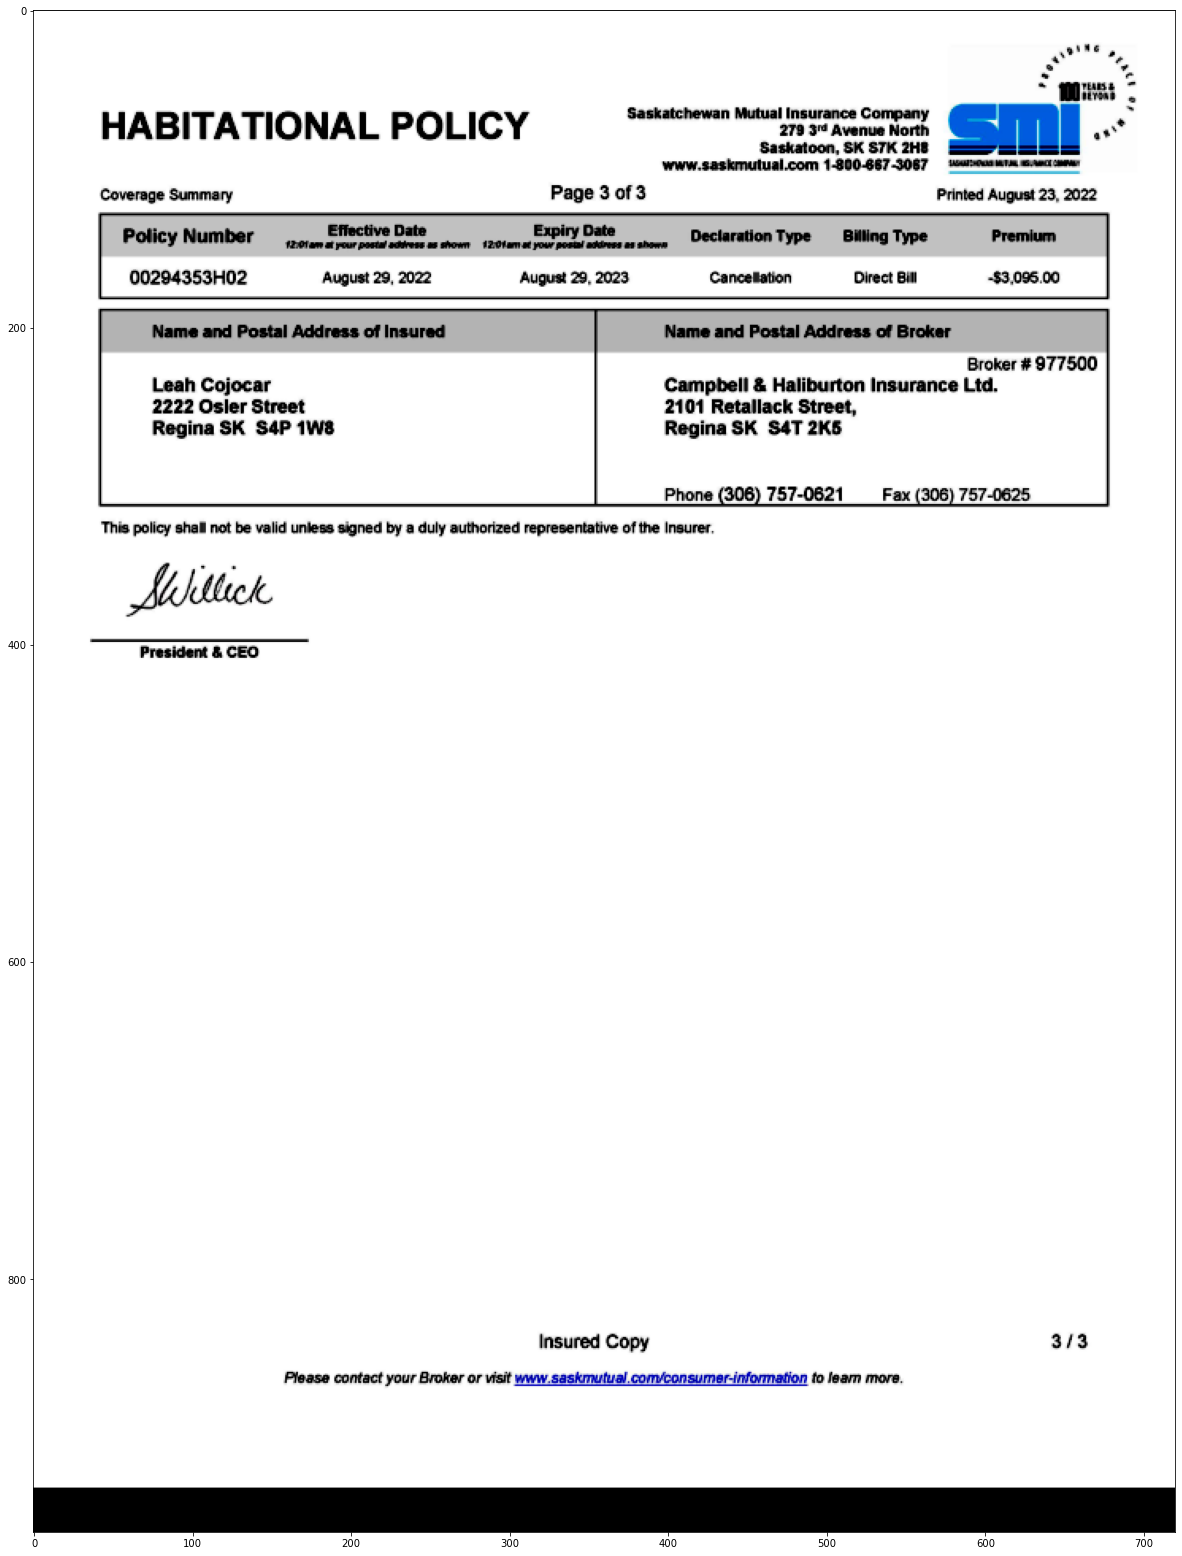

In [82]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (21, 28)

# Load random document image from the test set
test_sample = processed_dataset["test"][random.randint(1, 50)]
prediction, target = run_prediction(test_sample)
print(f"Reference:\n {target}")
print(f"Prediction:\n {prediction}")

pixels = np.transpose(np.array(test_sample["pixel_values"]), (1, 2, 0))
# Convert the numpy array to a PIL image object
img = plt.imshow(pixels)
img

In [96]:
from tqdm import tqdm
from datetime import datetime

# define counter for samples
true_counter = 0
total_counter = 0
field = 'effective_date'

# iterate over dataset
for sample in tqdm(processed_dataset["test"]):
  prediction, target = run_prediction(test_sample)
  datetime.strptime(prediction[field], '%B %d, %Y')


  0%|          | 0/87 [00:01<?, ?it/s]

August 29, 2022 
 August 29 , 2022
False


In [92]:
print(f"Accuracy for field: {field} is {(true_counter/total_counter)*100}%")

Accuracy for field: effective_date is 0.0%


In [98]:
from datetime import datetime
t = 'August 29, 2022'
datetime.strptime(t, '%B %d, %Y')


datetime.datetime(2022, 8, 29, 0, 0)

## Inference on a PDF

In [339]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [340]:
from pdf2image import convert_from_path
import glob

# Set the PDF file path
inference_path = '/home/harish3110/document-ai/data/inference/test_1/'
pdf_file_path = glob.glob(inference_path + '*.pdf')[0]
img_path = f"{inference_path}images"
os.makedirs(img_path, exist_ok=True)

# Convert PDF to a list of Pillow Image objects
images = convert_from_path(pdf_file_path)
# Save each image as a PNG file
for i, image in enumerate(images):
    image.save(f'{img_path}/page_{i+1}.jpeg', 'JPEG')

In [341]:
# Load dataset
path = Path(img_path)
inference_dataset = load_dataset("imagefolder", data_dir=path, split="train")

Using custom data configuration default-f1de38268fd684c4


Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /home/harish3110/.cache/huggingface/datasets/imagefolder/default-f1de38268fd684c4/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


In [342]:
print(f"Dataset has {len(inference_dataset)} images")

Dataset has 8 images


In [343]:
def preprocess_documents_for_donut_inference(sample):
    # convert all images to RGB
    image = sample["image"].convert('RGB')
    return {"image": image}

In [324]:
inference_proc_dataset = inference_dataset.map(preprocess_documents_for_donut_inference)

  0%|          | 0/8 [00:00<?, ?ex/s]

In [344]:
from transformers import DonutProcessor

# Load processor
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")

# # add new special tokens to tokenizer
# processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens + [task_start_token] + [eos_token]})

# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# resizing the image to smaller sizes from [1920, 2560] to [720, 960]
processor.feature_extractor.size = [720, 960] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/home/harish3110/mambaforge/lib/python3.9/site-packages/transformers/models/donut/processing_donut.py:186: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [345]:
def transform_and_tokenize_inference(sample, processor=processor, split="train", max_length=512, ignore_id=-100):
    # create tensor from image
    try:
        pixel_values = processor(
            sample["image"], random_padding=split == "train", return_tensors="pt"
        ).pixel_values.squeeze()
    except Exception as e:
        print(sample)
        print(f"Error: {e}")
        return {}
    return {"pixel_values": pixel_values}

inference_processed_dataset = inference_proc_dataset.map(transform_and_tokenize_inference,remove_columns=["image"])

Loading cached processed dataset at /home/harish3110/.cache/huggingface/datasets/imagefolder/default-ca0ff8a92c6dad2b/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-9aaa45acb5bbe2fe.arrow


In [346]:
def run_inference(sample, model=model, processor=processor):
    # prepare inputs
    pixel_values = torch.tensor(sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)
    return prediction

In [358]:
index = 2
prediction = run_inference(inference_processed_dataset[index], model=new_model, processor=processor)
prediction

{'premium': '$ 2,107.00',
 'policy_number': '31932660',
 'expiry_date': 'August 31, 2022',
 'effective_document_date': 'August 31, 2021',
 'effective_date': 'August 31, 2021',
 'document_type_description': 'Renewal Declaration effective',
 'document_type': 'INSURANCE POLICY'}

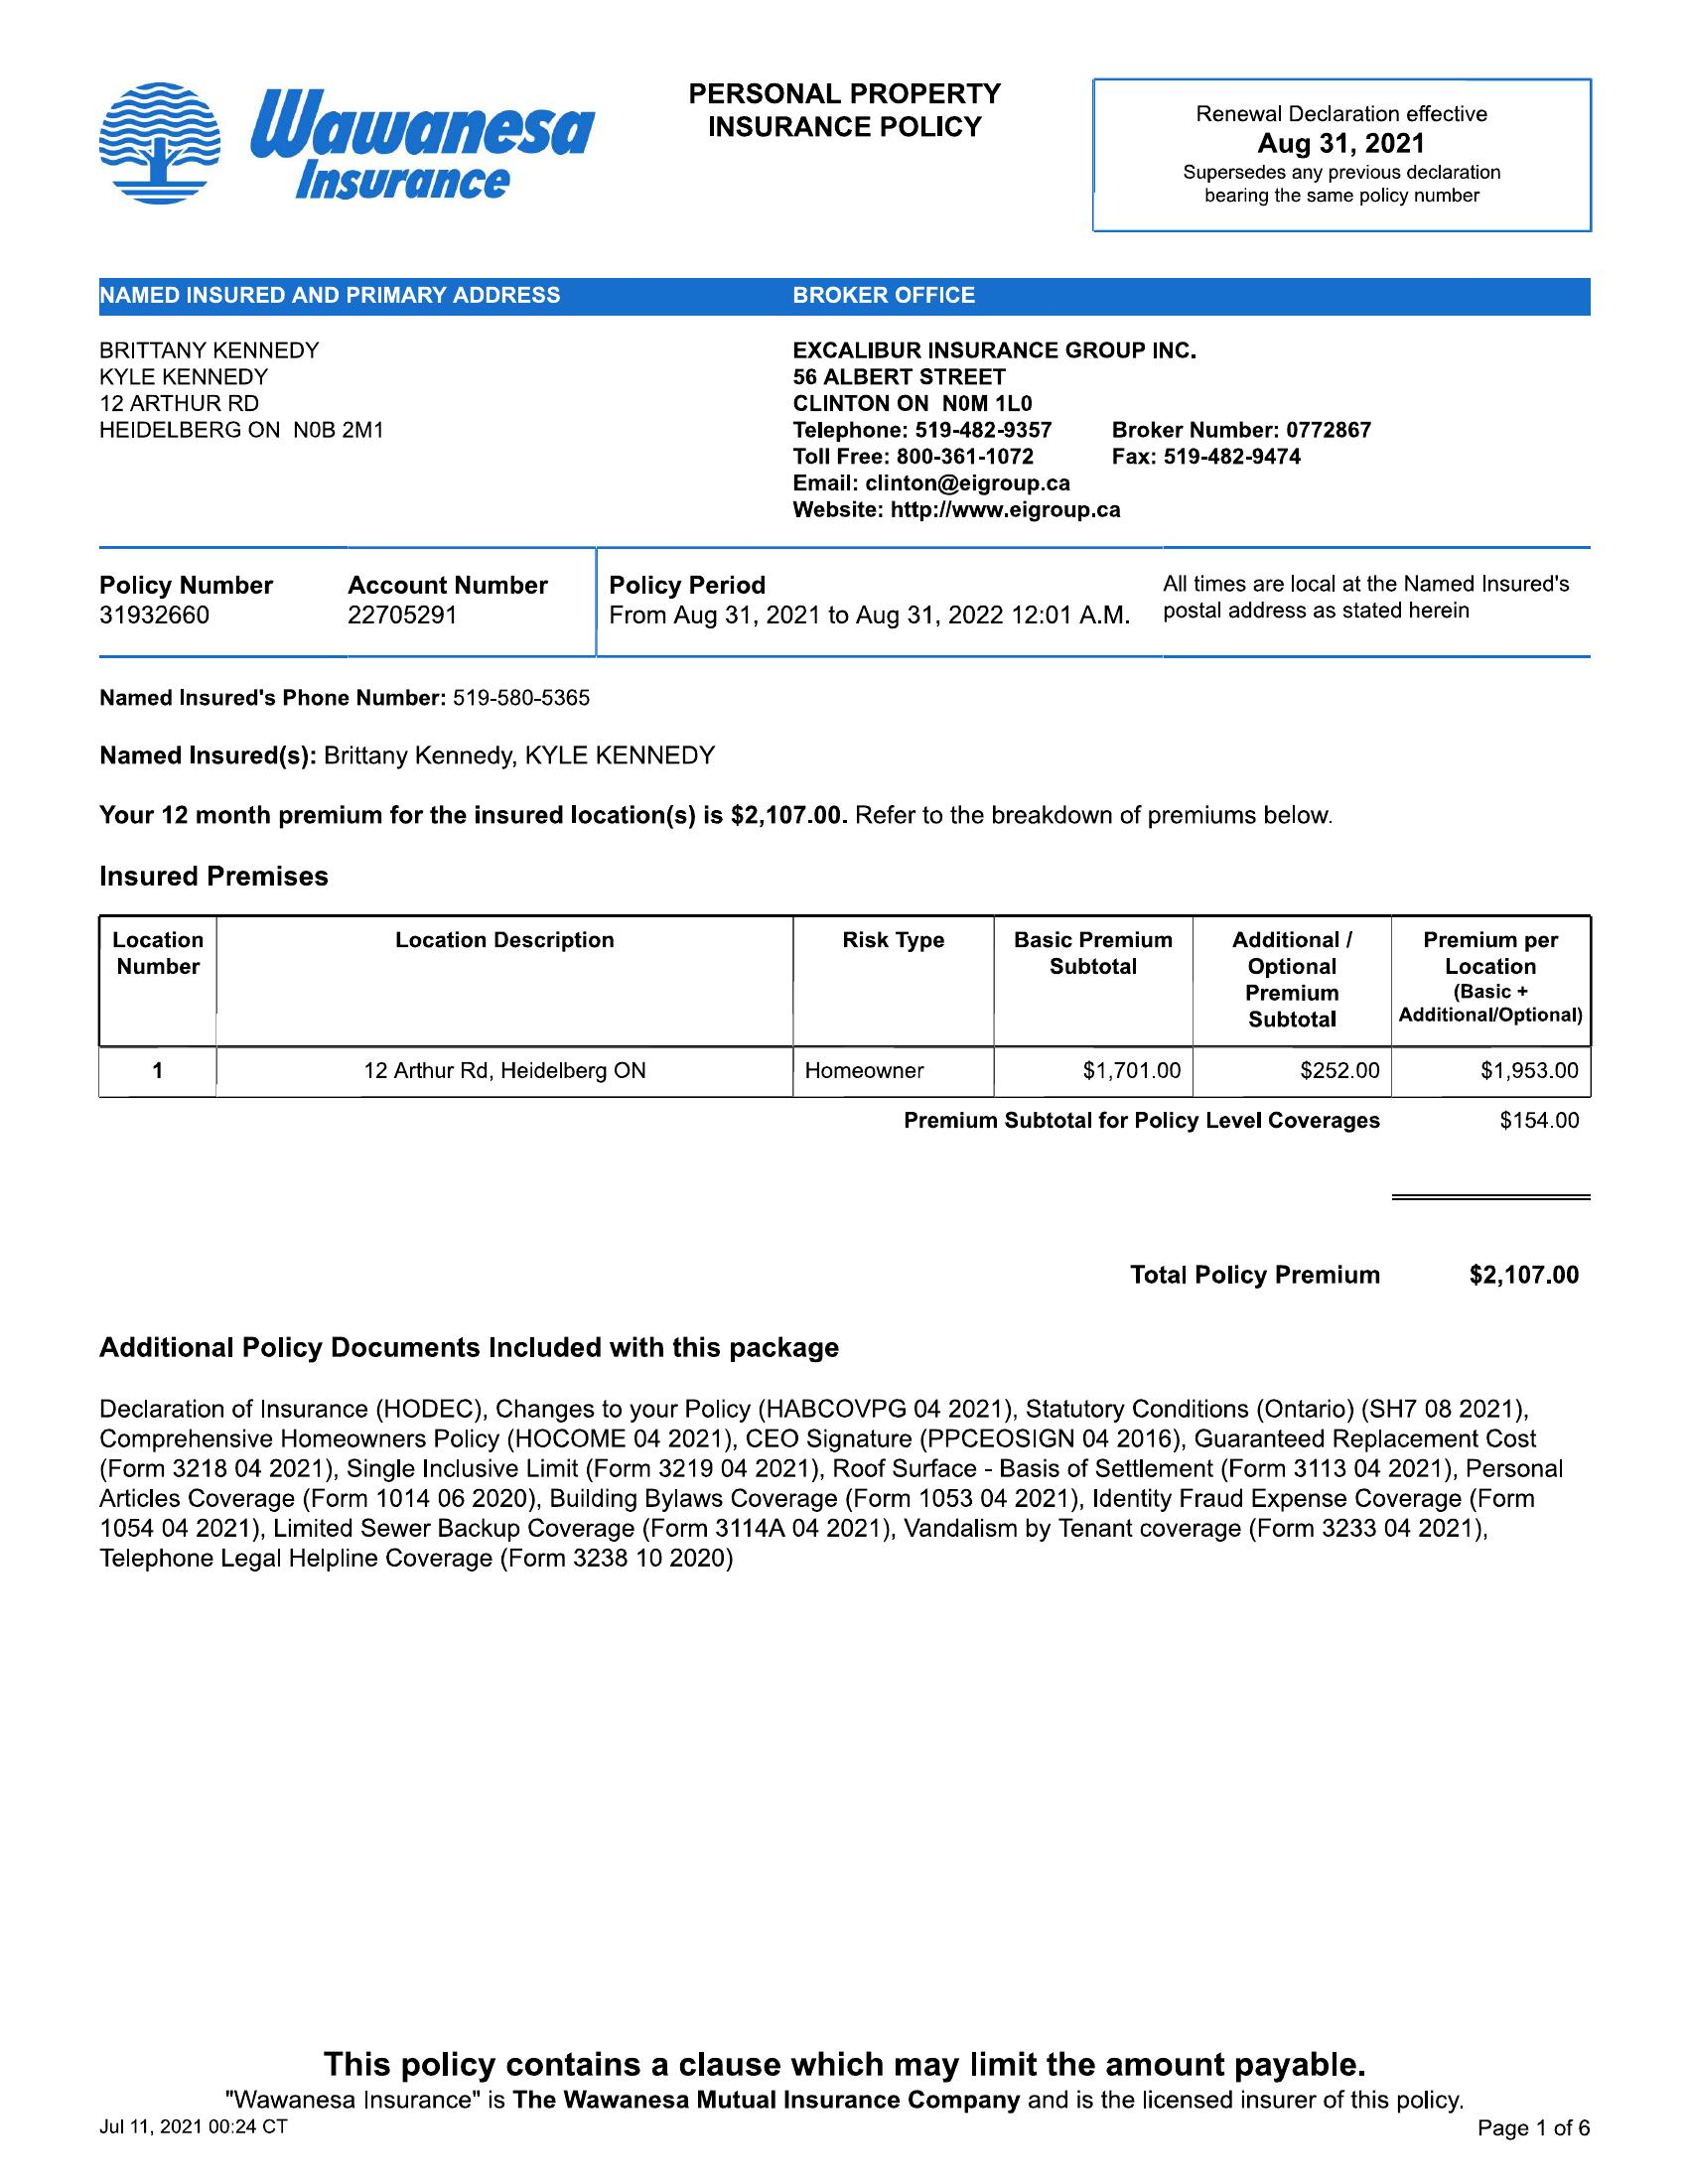

In [349]:
inference_dataset[index]['image']

In [350]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /home/harish3110/.cache/huggingface/token
Login successful


In [352]:
trainer.save_model("/home/harish3110/document-ai/data/models/donut-quandri-v1")

In [357]:
new_model = VisionEncoderDecoderModel.from_pretrained("/home/harish3110/document-ai/data/models/donut-quandri-v1")
device = "cuda" if torch.cuda.is_available() else "cpu"
new_model.to(device)

VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0-1): 2 x DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
           